# Deriving R<sub>0</sub> (Basic Reproductive Number) in Sympy and PyGOM

In [ ]:
#Set up sympy to display outputs as mathmatical formula as opposed to latex.
from sympy.interactive import printing
printing.init_printing(use_latex=True)

For this notebook we will be following the example given in section 2.1 of:

Diekmann, O., Heesterbeek, J. A. P., & Roberts, M. G. (2010). The construction of next-generation matrices for compartmental epidemic models. Journal of the Royal Society Interface, 7(47), 873–885. https://doi.org/10.1098/rsif.2009.0386

## 1. Deriving R0 (Basic Reproductive Number) in Sympy

In [15]:
# First we need to import sympy
import sympy 
# We also need to import copy for copying items
import copy

### 1.2 Setup Model

In [16]:
# Setup Symbols for Sympy
N, S, E_1, E_2, I, R, mu, beta, p, nu_1, nu_2, gamma = sympy.symbols('N S E_1 E_2 I R mu beta p nu_1 nu_2 gamma')

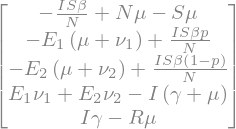

In [17]:
# The system can be described as
ODE_S = mu*N-beta*S*I/N-mu*S
ODE_E_1 = p*beta*S*I/N-(mu+nu_1)*E_1
ODE_E_2 = (1-p)*beta*S*I/N-(mu+nu_2)*E_2
ODE_I = nu_1*E_1+nu_2*E_2-(mu+gamma)*I
ODE_R = gamma*I-mu*R

ODEs = sympy.Matrix([ODE_S,ODE_E_1,ODE_E_2,ODE_I,ODE_R])
ODEs

## 1.2 Get jacobian of infected stages

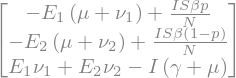

In [18]:
# We are only interested in the, latent and infectious compartments
ODEs_infecteds = sympy.Matrix([ODE_E_1,ODE_E_2,ODE_I])
ODEs_infecteds

## 1.3 Obtainning matrix  of transitions between or out of infectious stages ($\Sigma$)

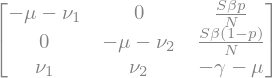

In [19]:
# The jacobian of the infecteds
jacobian_of_infecteds = ODEs_infecteds.jacobian(X=[E_1, E_2, I])
jacobian_of_infecteds

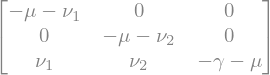

In [30]:
# e.g. removing people becoming infected from the jacobian above.
Sigma = copy.deepcopy(jacobian_of_infecteds)
Sigma[0,2] = 0 # Sigma[0,2] = Sigma[0,2]-S*beta*p/N would work to. .subs method can also be used see below.
Sigma[1,2] = Sigma[1,2]-S*beta*(1-p)/N # Sigma[1,2] = 0 would work to. .subs method can also be used see below.
Sigma

## 1.4 Obtainning matrix  of transitions into of infectious stages (T)

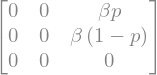

In [21]:
# E.g. removing people transitioning from the jacobian above.
# Suggest not use T to name a variable could be confused with transpose of a matrix.
T_inf_births = jacobian_of_infecteds.subs({N:1, S:1, mu:0, nu_1:0, nu_2:0, gamma:0})
T_inf_births

## 1.5 Obtainning Next Geneation Matrix (K<sub>L</sub>).

In [22]:
Sigma_inv = Sigma**-1 # note for powers in python it is ** not ^.
neg_Sigma_inv = -Sigma_inv

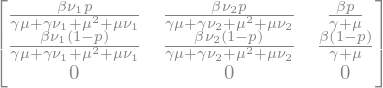

In [23]:
K_L = T_inf_births*neg_Sigma_inv
K_L

## 1.6 Finally the Basic Reproductive Number (R<sub>0</sub>)

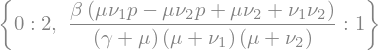

In [24]:
eigen_values = K_L.eigenvals()
eigen_values

In [25]:
none_zero_eigen_values = [item for item in eigen_values.keys() if item !=0]

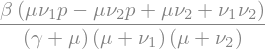

In [26]:
sympy_R0 = none_zero_eigen_values[0]
sympy_R0

Lets just sense check that against the Diekmann et al (2010) publication

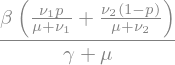

In [27]:
diekman_R0 = (p*nu_1/(nu_1+mu)+(1-p)*nu_2/(nu_2+mu))*beta/(gamma+mu)
diekman_R0

In [28]:
sympy.simplify(sympy_R0 - diekman_R0)==0

True

### 1.6.1 Printing Basic Reproductive Number (R<sub>0</sub>) in latex form for right up.

In [29]:
sympy.print_latex(sympy_R0)

\frac{\beta \left(\mu \nu_{1} p - \mu \nu_{2} p + \mu \nu_{2} + \nu_{1} \nu_{2}\right)}{\left(\gamma + \mu\right) \left(\mu + \nu_{1}\right) \left(\mu + \nu_{2}\right)}


## 2. Deriving the Basic Reproductive Number (R<sub>0</sub>) in PyGOM

### 2.1 Setting up parameters and variables in PyGOM

In [31]:
import pygom

variables = ['S', 'E_1', 'E_2', 'I', 'R' ]
params = ['mu', 'beta', 'p', 'nu_1', 'nu_2', 'gamma', 'N'] # Note N does not change in this model so we are treating it as a parameter.

### 2.2 Defining the model as birth, death and transfer transistions

**Note** whilst you can setup models in PyGOM with ODE transitions, in order for PyGOM's R<sub>0</sub> function to work the model object must be defined through transfer transistions.

#### 2.2.1 Birth and Death transitions

In [32]:
birth_death = [pygom.Transition(origin='S',
                                equation='N*mu',
                                transition_type='B'),
               pygom.Transition(origin='S',
                                equation='S*mu',
                                transition_type='D'),
               pygom.Transition(origin='I',
                                equation='I*mu',
                                transition_type='D'),
               pygom.Transition(origin='E_1',
                                equation='E_1*mu',
                                transition_type='D'),
               pygom.Transition(origin='E_2',
                                equation='E_2*mu',
                                transition_type='D'),
               pygom.Transition(origin='R',
                                equation='R*mu',
                                transition_type='D')]

#### 2.2.2 Transfer transitions

In [33]:
transfers = [pygom.Transition(origin='S',
                              equation='S*I/N*p*beta',
                              destination='E_1',
                              transition_type='T'),
             pygom.Transition(origin='S',
                              equation='S*I/N*(1-p)*beta',
                              destination='E_2',
                              transition_type='T'),
             pygom.Transition(origin='E_1',
                              equation='E_1*nu_1',
                              destination='I',
                              transition_type='T'),
             pygom.Transition(origin='E_2',
                              equation='E_2*nu_2',
                              destination='I',
                              transition_type='T'),
             pygom.Transition(origin='I',
                              equation='I*gamma',
                              destination='R',
                              transition_type='T'),
            ]

#### 2.2.3 Defining PyGOM model class

In [34]:
pygom_model = pygom.SimulateOde(state=variables,
                                param=params,
                                birth_death=birth_death,
                                transition=transfers)                                   

In [35]:
pygom_model.print_ode()

⎡            I⋅S⋅β⋅p   I⋅S⋅β⋅(1 - p)            ⎤
⎢ dS/dt=   - ─────── - ───────────── + N⋅μ - S⋅μ⎥
⎢               N            N                  ⎥
⎢                                               ⎥
⎢                                 I⋅S⋅β⋅p       ⎥
⎢dE_1/dt=         -E₁⋅μ - E₁⋅ν₁ + ───────       ⎥
⎢                                    N          ⎥
⎢                                               ⎥
⎢                              I⋅S⋅β⋅(1 - p)    ⎥
⎢dE_2/dt=      -E₂⋅μ - E₂⋅ν₂ + ─────────────    ⎥
⎢                                    N          ⎥
⎢                                               ⎥
⎢ dI/dt=         E₁⋅ν₁ + E₂⋅ν₂ - I⋅γ - I⋅μ      ⎥
⎢                                               ⎥
⎣ dR/dt=                 I⋅γ - R⋅μ              ⎦


### 2.3 Using PyGOM's R<sub>0</sub> function.

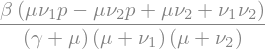

In [36]:
pygom_R0 = pygom.R0(ode=pygom_model, disease_state=['E_1', 'E_2', 'I'])
pygom_R0

Lets just sense check that against the sympyR0.
**Note** you will have to check for equality visually, but they are the same statement. Sometimes checking for equality of symbolic expressions for sympy can be difficult.

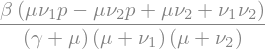

In [37]:
sympy_R0